In [1]:
from __future__ import annotations
"""
This is a notebook with a collecion of attempts at extracting binding vectors and/or subspaces
from thee papers:
- https://arxiv.org/pdf/2310.17191
- https://arxiv.org/pdf/2406.19501

There is a method provided in the second paper's github: https://github.com/jiahai-feng/prop-probes-iclr
... but I only skimmed it and might not fully utilize it if something simpler works.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import random
import numpy as np
import itertools
import transformer_lens
import math
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
import sae_lens
from sae_lens import HookedSAETransformer, SAE
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import functools as Ft
import tqdm
from typing import List, Dict, Tuple, Optional, Union, Callable

device = "cuda:0" # NOTE: modify me!

In [2]:
"""
Here we try something simpler than the algorithm proposed by Jiahai: we simply calculate the principle
components of a shit-load of vectors that we believe should be in the binding suspace. We find these vectors
by taking the differences of various bound components like in the first paper (https://arxiv.org/pdf/2310.17191) and
then noting that these should be in the binding subspace.

We work on a small model to begin with. The cells below continue until this is done.

BTW in general if you think there is a subspace that multiple vectors lie on you can do this ^ or you can also do OLS
to learn the weights of a projection matrix (where basically you train the projection matrix to be idempotent on
these vectors).


"""
hf_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

model = HookedTransformer.from_pretrained(model_name = "gemma-2-2b-it", device = device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gemma-2-2b-it into HookedTransformer


In [13]:
print("Available Parameter names (probably hook points?)")
print("\n".join(n for n, _ in model.named_modules() if isinstance(_, HookPoint)))
# print(model) # alternative here

Available Parameter names (probably hook points?)
hook_embed
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln1_post.hook_scale
blocks.0.ln1_post.hook_normalized
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.ln2_post.hook_scale
blocks.0.ln2_post.hook_normalized
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_pre_linear
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_mid
blocks.0.hook_resid_post
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln1_post.hook_scale
blocks.1.ln1_post.hook_normalized
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.ln2_post.h

In [3]:
"""
Utility functions that we use to basically collect activations, etc...
"""

def collect_activations_hook(
        # Input
        activation: torch.Tensor,
        # HTF thing
        hook: HookPoint,
        # We will be saving to a tensor
        activations_save_loc: torch.Tensor,
         # Pass these below for sanity t esting
        left: int,
        right: int,
        model_dim: int,
        seq_len: int,
        hook_idx: int,
    ):
    """
    A simple hook function to used in `collect_all_activations` to save a buncha activations.
    """
    # Sanity check activations
    assert activation.ndim == 3, f"activation.ndim = {activation.ndim}" # fmt: skip
    assert activation.shape[0] == right - left, f"activation.shape[0] = {activation.shape[0]}, right - left = {right - left}" # fmt: skip
    assert activation.shape[1] == seq_len, f"activation.shape[1] = {activation.shape[1]}, model_seq_size = {seq_len}" # fmt: skip
    assert activation.shape[2] == model_dim, f"activation.shape[2] = {activation.shape[2]}, model_dim = {model_dim}" # fmt: skip

    # Sanity check outputs
    assert activations_save_loc.ndim == 4
    assert 0 <= hook_idx < activations_save_loc.shape[0]
    assert 0 <= left < right <= activations_save_loc.shape[1]
    assert 0 <= activation.shape[1] == activations_save_loc.shape[2]
    assert 0 <= activation.shape[2] == activations_save_loc.shape[3]

    # Store SAE IO
    activations_save_loc[hook_idx, left:right, :, :] = activation.detach().cpu()
    return activation


@torch.no_grad()
def collect_all_activations(
        model: HookedTransformer,
        inputs: torch.Tensor,
        hook_names: List[str],
        inference_batch_size: int = 20,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    TODO(Adriano): support a boolean mask to exclude EOS.
    """
    assert isinstance(hook_names, list), f"hook_names is not a list: {hook_names}" # fmt: skip
    assert all([isinstance(hook_name, str) for hook_name in hook_names]), f"hook_names is not a list of strings: {hook_names}" # fmt: skip
    assert isinstance(inputs, torch.Tensor), f"inputs is not a torch.Tensor: {inputs}" # fmt: skip
    assert inputs.ndim == 2, f"inputs.ndim = {inputs.ndim}" # fmt: skip
    assert isinstance(inference_batch_size, int), f"inference_batch_size is not an int: {inference_batch_size}" # fmt: skip
    assert inference_batch_size > 0, f"inference_batch_size is not positive: {inference_batch_size}" # fmt: skip
    model_training = model.training
    model.eval()
    try:
        assert inputs.ndim == 2
        total_batch_size, seq_len = inputs.shape
        model_dim = model.cfg.d_model
        rnd_sans = (torch.randn(1) * 9999999).item()
        outputs = rnd_sans * torch.ones(len(hook_names), total_batch_size, seq_len, model_dim)
        losses = torch.zeros(math.ceil(total_batch_size / inference_batch_size),)
        pbar = tqdm.trange(0, inputs.shape[0], inference_batch_size)
        for i, left in enumerate(pbar):
            right = min(left+inference_batch_size, total_batch_size)
            assert right > left and right <= total_batch_size
            loss = model.run_with_hooks(
                inputs[left:right],
                # fwd_hooks=[],
                fwd_hooks=[
                        (
                            hook_name,
                            Ft.partial(
                                collect_activations_hook,
                                activations_save_loc=outputs,
                                left=left,
                                right=right,
                                model_dim=model_dim,
                                seq_len=seq_len,
                                hook_idx=h,
                            ),
                        ) for h, hook_name in enumerate(hook_names)
                ],
                return_type="loss",
            )
            losses[i] = loss.item()
            pbar.set_description(f"Average loss is: {torch.mean(losses[:i+1]).item()}")
        assert torch.all(outputs != rnd_sans).item(), f"Some torch outputs ({(outputs == rnd_sans).sum()}/{outputs.numel()}) appear to equal rnd_sans" # fmt: skip
        return outputs, losses
    finally:
        model.train(model_training)

# Test that we are able to collet some activations
test_hook_names = ["blocks.14.hook_resid_pre"]
test_msg = "I am a happy watermelon. Every day I roll roll roll down the hill to see my friend the"
test_tok = hf_tokenizer(test_msg, return_tensors = "pt").to(device)["input_ids"]
test_resp_tok = model.generate(test_tok, max_new_tokens = 32)
test_resp = hf_tokenizer.decode(test_resp_tok[0], skip_special_tokens = True)
# debug
test_brk = "\n" + "="*100 + "\n"
print(test_msg, test_brk, test_tok, test_brk, test_resp_tok, test_brk, test_resp)

# run em
outputs, losses = collect_all_activations(model, test_tok, test_hook_names, inference_batch_size=20)
print(f"Outputs has shape: {outputs.shape}")
print(f"Losses has shape {losses.shape}")

  0%|          | 0/32 [00:00<?, ?it/s]

I am a happy watermelon. Every day I roll roll roll down the hill to see my friend the 
 tensor([[     2, 235285,   1144,    476,   4915,  87171, 235265,   7205,   1744,
            590,   9993,   9993,   9993,   1706,    573,  16090,    577,   1443,
            970,   4034,    573]], device='cuda:0') 
 tensor([[     2, 235285,   1144,    476,   4915,  87171, 235265,   7205,   1744,
            590,   9993,   9993,   9993,   1706,    573,  16090,    577,   1443,
            970,   4034,    573,   7786,  32145, 235265,   1448,   4664,    731,
            573,  25757, 235265,    139,  62614,    576,   4707,    603,    970,
           7827, 235341,   2961,   3760,    603,    712,   4915,   1185,    573,
          60461,   2238, 235269,   1154,    476,   8811,    576,  60461]],
       device='cuda:0') 
 I am a happy watermelon. Every day I roll roll roll down the hill to see my friend the sweet cherry. We meet by the fence.  Fourth of July is my favorite! My heart is so happy when the fire

Average loss is: 3.745002031326294: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

Outputs has shape: torch.Size([1, 1, 21, 2304])
Losses has shape torch.Size([1])


In [4]:
"""
Mostly copied stuff from `entity-binding.ipynb` by Jim Marr @ MATS training phase 2025.
"""
class BindingPromptsGenerator:
    """
    Static class to create prompts for binding experiments. They usually say: {subject} {relation} {object} for example:
    "Adam likes apples" or "John likes pizza" or "Alice lives in France" etc...
    """

    # Static variables used for binding experiments
    country_list = ['Thailand', 'Japan', 'Brazil', 'Morocco', 'Sweden', 'Kenya', 'Argentina', 'Australia', 'Egypt', 'Canada', 'Vietnam', 'Portugal', 'India', 'Norway', 'Mexico', 'Malaysia', 'Greece', 'Finland', 'Indonesia', 'Turkey', 'Chile', 'Ireland', 'Bangladesh', 'Denmark', 'Peru', 'Iceland', 'Colombia', 'Singapore', 'Austria', 'Nigeria', 'Croatia', 'Taiwan', 'Switzerland', 'Ghana', 'Cambodia', 'Poland', 'Nepal', 'Uruguay', 'Tanzania', 'Belgium', 'Jordan', 'Hungary', 'Bhutan', 'Maldives', 'Venezuela', 'Laos', 'Romania', 'Somalia', 'Mongolia', 'Uzbekistan'] # fmt: skip
    name_list = ['Emma', 'James', 'Luna', 'Kai', 'Zara', 'Leo', 'Maya', 'Finn', 'Nova', 'Atlas', 'Rose', 'Sage', 'Jack', 'Ruby', 'Owen', 'Grace', 'Dean', 'Hope', 'Blake', 'Dawn', 'Cole', 'Faith', 'Reed', 'Sky', 'Jade', 'Wolf', 'Rain', 'Quinn', 'Blaze', 'Pearl', 'Felix', 'Iris', 'Seth', 'Dove', 'Drake', 'Joy', 'Axel', 'Fern', 'Stone', 'Wren', 'Grant', 'Hazel', 'Brooks', 'Ash', 'Reid', 'Sage', 'Clark', 'Skye', 'Blair', 'Scout'] # fmt: skip
    capital_list = ['Bangkok', 'Tokyo', 'Brasilia', 'Rabat', 'Stockholm', 'Nairobi', 'Buenos Aires', 'Canberra', 'Cairo', 'Ottawa', 'Hanoi', 'Lisbon', 'New Delhi', 'Oslo', 'Mexico City', 'Kuala Lumpur', 'Athens', 'Helsinki', 'Jakarta', 'Ankara', 'Santiago', 'Dublin', 'Dhaka', 'Copenhagen', 'Lima', 'Reykjavik', 'Bogota', 'Singapore', 'Vienna', 'Abuja', 'Zagreb', 'Taipei', 'Bern', 'Accra', 'Phnom Penh', 'Warsaw', 'Kathmandu', 'Montevideo', 'Dodoma', 'Brussels', 'Amman', 'Budapest', 'Thimphu', 'Male', 'Caracas', 'Vientiane', 'Bucharest', 'Mogadishu', 'Ulaanbaatar', 'Tashkent'] # fmt: skip
    capital_list = [f" {capital}" for capital in capital_list] # fmt: skip
    fruit_list = ['orange', 'zucchini', 'xigua', 'uva', 'papaya', 'elderberry', 'banana', 'fig', 'vanilla', 'mango', 'quince', 'pomegranate', 'yuzu', 'lemon', 'peach', 'saffron', 'date', 'strawberry', 'kiwi', 'grape', 'honeydew', 'quinoa', 'pear', 'rhubarb', 'cherry', 'raspberry', 'apple', 'tangerine', 'pineapple', 'plum', 'tomato', 'watermelon', 'prune', 'raisin'] # fmt: skip
    fruit_list = [f" {fruit}" for fruit in fruit_list] # fmt: skip

    @staticmethod
    def get_one_token_lists(lists: List[List[str]]) -> List[List[str]]:
        assert len(lists) > 0
        assert type(lists[0]) is list
        list_len = len(lists[0])
        assert all([len(l) == list_len for l in lists])
        one_token_indices = []
        for i in range(list_len):
            is_one_token = True
            for j in range(len(lists)):
                name = lists[j][i]
                toks = model.to_tokens(name, prepend_bos=False)[0]
                if len(toks) > 1:
                    is_one_token = False
                    break
                if name[0] == ' ':
                    continue
                toks = model.to_tokens(f" {name}", prepend_bos=False)[0]
                if len(toks) > 1:
                    is_one_token = False
                    break
            if is_one_token:
                one_token_indices += [i]
        new_lists = [[] for _ in range(len(lists))]
        for idx in one_token_indices:
            for j in range(len(lists)):
                new_lists[j] += [lists[j][idx]]
        assert isinstance(new_lists, list), f"new_lists is not a list: {new_lists}" # fmt: skip
        assert all([isinstance(l, list) for l in new_lists]), f"new_lists is not a list of lists: {new_lists}" # fmt: skip
        assert all(all([isinstance(e, str) for e in l]) for l in new_lists), f"new_lists is not a list of lists of strings: {new_lists}" # fmt: skip
        return new_lists
    
    @staticmethod
    def get_prompt_capital(qn_subject: str, entities: List[str], attributes: List[str]) -> str: # fmt: skip
        assert len(entities) == len(attributes)
        n = len(entities)
        return (
            "Answer the question based on the context below. Keep the answer short.\n" + # fmt: skip
            "Context: " + "\n".join([f'{entities[i]} lives in the capital city of {attributes[i]}.' for i in range(n)]) + # fmt: skip
            '\n' +
            f"Question: Which city does {qn_subject} live in?\n" + # fmt: skip
            f"Answer: {qn_subject} lives in the city of" # fmt: skip
        )

    @staticmethod
    def get_prompt_fruit(qn_subject: str, entities: List[str], attributes: List[str]) -> str:
        assert len(entities) == len(attributes)
        n = len(entities)
        return (
            "Answer the question based on the context below. Keep the answer short.\n" + # fmt: skip
            "Context: " + ". ".join([f"{entities[i]} likes eating the{attributes[i]}" for i in range(n)]) + "\nrespectively.\n" + # fmt: skip
            f"Question: What food does {qn_subject} like?\n" + # fmt: skip
            f"Answer: {qn_subject} likes the" # fmt: skip
        )

    @staticmethod
    def get_prompts(
            batch_size: int,
            entities: List[str],
            attributes: List[str],
            get_prompt_function: Callable,
            answer_list: Optional[List[str]] = None,
            num_pairs: int = 2,
        ) -> Tuple[List[str], List[str], List[str]]:
        # sample n pairs of country+capital and n pairs of name+name
        prompts = []
        correct_answers = []
        incorrect_answers = []
        
        # Sample n countries and n names without replacement
        entities_list = []
        attributes_list = []
        for i in range(batch_size):
            ents = random.sample(entities, num_pairs)
            attrs = random.sample(attributes, num_pairs)
            entities_list.append(ents)
            attributes_list.append(attrs)
        
        for i in range(batch_size):
            # For each prompt, we need 2 different countries and 2 different names
            ents = entities_list[i]
            attrs = attributes_list[i]
            qn_subject = random.choice(ents)
            correct_entity_idx = ents.index(qn_subject)
            attribute = attrs[correct_entity_idx]
            incorrect_attributes = attrs.copy()
            incorrect_attributes.remove(attribute)
            incorrect_attribute = random.choice(incorrect_attributes)
            if answer_list is not None:
                correct_answer = answer_list[attributes.index(attribute)]
                incorrect_answer = answer_list[attributes.index(incorrect_attribute)]
            else:
                correct_answer = attribute
                incorrect_answer = incorrect_attribute

            prompt = get_prompt_function(qn_subject, ents, attrs)
            prompts.append(prompt)
            correct_answers.append(correct_answer)
            incorrect_answers.append(incorrect_answer)
        return prompts, correct_answers, incorrect_answers

    


#### TEST (also copied from before) ####
do_test1 = True
if do_test1:
    name_list_one_token = BindingPromptsGenerator.get_one_token_lists([BindingPromptsGenerator.name_list])[0] # fmt: skip
    country_list_one_token, capital_list_one_token = BindingPromptsGenerator.get_one_token_lists([BindingPromptsGenerator.country_list, BindingPromptsGenerator.capital_list]) # fmt: skip
    fruit_list_one_token = BindingPromptsGenerator.get_one_token_lists([BindingPromptsGenerator.fruit_list])[0] # fmt: skip
    print("Expected")
    print("37 37 49 29")
    print("Found")
    print(len(country_list_one_token), len(capital_list_one_token), len(name_list_one_token), len(fruit_list_one_token)) # fmt: skip
    n_poss_country_name_relation = len(country_list_one_token) * len(name_list_one_token)
    n_poss_fruit_name_relation = len(fruit_list_one_token) * len(name_list_one_token)
    n_tot_poss_relations = n_poss_country_name_relation + n_poss_fruit_name_relation
    print(f"Possible number of datapoints = country*name + fruit*name={n_poss_country_name_relation}+{n_poss_fruit_name_relation}={n_tot_poss_relations}") # fmt: skip
    print(f"Note that model_dim={model.cfg.d_model}; we need the datapoints # to be BIGGER than this!")
do_test2 = True
if do_test2:
    n = 100
    num_pairs = 2
    prompts_capital, correct_answers_capital, incorrect_answers_capital = BindingPromptsGenerator.get_prompts(n, name_list_one_token, country_list_one_token, BindingPromptsGenerator.get_prompt_capital, capital_list_one_token, num_pairs) # fmt: skip
    prompts_fruit, correct_answers_fruit, incorrect_answers_fruit = BindingPromptsGenerator.get_prompts(n, name_list_one_token, fruit_list_one_token, BindingPromptsGenerator.get_prompt_fruit, num_pairs=num_pairs) # fmt: skip
    input_toks_capital = model.to_tokens(prompts_capital)
    correct_toks_capital = model.to_tokens(correct_answers_capital, prepend_bos=False)[:, 0]
    incorrect_toks_capital = model.to_tokens(incorrect_answers_capital, prepend_bos=False)[:, 0]
    input_toks_fruit = model.to_tokens(prompts_fruit)
    correct_toks_fruit = model.to_tokens(correct_answers_fruit, prepend_bos=False)[:, 0]
    incorrect_toks_fruit = model.to_tokens(incorrect_answers_fruit, prepend_bos=False)[:, 0]
    print("Expected")
    print("torch.Size([100, 56]) torch.Size([100]) torch.Size([100])")
    print("torch.Size([100, 47]) torch.Size([100]) torch.Size([100])")
    print("Found")
    print(input_toks_capital.shape, correct_toks_capital.shape, incorrect_toks_capital.shape)
    print(input_toks_fruit.shape, correct_toks_fruit.shape, incorrect_toks_fruit.shape)
    print("="*100)
    print("Some examples")
    print("="*50)
    # print("model from tokens:", model.from_tokens(input_toks_capital[0], prepend_bos=False))
    print("hf tokenizer decode:")
    print("="*50)
    print(hf_tokenizer.decode(input_toks_capital[0], skip_special_tokens=True))
################################ DATASET CREATION #################################
# Create the cartesian product of possibilities for our dataset
# NOTE: scrapped this since I think it's probably not necessary
# names_combos = list(map(list, itertools.combinations(name_list_one_token, 2)))
# countries_combos = list(map(list, itertools.combinations(country_list_one_token, 2)))
# fruits_combos = list(map(list, itertools.combinations(fruit_list_one_token, 2)))
# # ...
# assert len(names_combos) == len(name_list_one_token) * (len(name_list_one_token) - 1) // 2
# names_countries = list(itertools.product(names_combos, countries_combos))
# names_fruits = list(itertools.product(names_combos, fruits_combos))
# names_countries_prompts = [
#     BindingPromptsGenerator.get_prompt_capital(qn_subject=names[i%2], entities=names, attributes=countries)
#     for i, (names, countries) in enumerate(names_countries)
# ]
# names_fruits_prompts = [
#     BindingPromptsGenerator.get_prompt_fruit(qn_subject=names[i%2], entities=names, attributes=fruits)
#     for i, (names, fruits) in enumerate(names_fruits)
# ]
# print("n_combos_names_countries_prompts:", len(names_countries_prompts))
# print("n_combos_names_fruits_prompts:", len(names_fruits_prompts))
random.seed(42)
n_samples_4pca = 5000
n_pairs_4pca = 2
prompts_capital, correct_answers_capital, incorrect_answers_capital = BindingPromptsGenerator.get_prompts(n_samples_4pca, name_list_one_token, country_list_one_token, BindingPromptsGenerator.get_prompt_capital, capital_list_one_token, num_pairs) # fmt: skip
prompts_fruit, correct_answers_fruit, incorrect_answers_fruit = BindingPromptsGenerator.get_prompts(n_samples_4pca, name_list_one_token, fruit_list_one_token, BindingPromptsGenerator.get_prompt_fruit, num_pairs=num_pairs) # fmt: skip
prompt_capital2i = {prompt: i for i, prompt in enumerate(prompts_capital)}
prompt_fruit2i = {prompt: i for i, prompt in enumerate(prompts_fruit)}

# Get deduplicated prompts/etc...
prompts_capital_dedup = list(set(prompts_capital))
prompts_fruit_dedup = list(set(prompts_fruit))
correct_answers_capital_dedup = [correct_answers_capital[prompt_capital2i[prompt]] for prompt in prompts_capital_dedup]
correct_answers_fruit_dedup = [correct_answers_fruit[prompt_fruit2i[prompt]] for prompt in prompts_fruit_dedup]
incorrect_answers_capital_dedup = [incorrect_answers_capital[prompt_capital2i[prompt]] for prompt in prompts_capital_dedup]
incorrect_answers_fruit_dedup = [incorrect_answers_fruit[prompt_fruit2i[prompt]] for prompt in prompts_fruit_dedup]
input_toks_capital_dedup = model.to_tokens(prompts_capital_dedup)
correct_toks_capital_dedup = model.to_tokens(correct_answers_capital_dedup, prepend_bos=False)[:, 0]
incorrect_toks_capital_dedup = model.to_tokens(incorrect_answers_capital_dedup, prepend_bos=False)[:, 0]
input_toks_fruit_dedup = model.to_tokens(prompts_fruit_dedup)
correct_toks_fruit_dedup = model.to_tokens(correct_answers_fruit_dedup, prepend_bos=False)[:, 0]
incorrect_toks_fruit_dedup = model.to_tokens(incorrect_answers_fruit_dedup, prepend_bos=False)[:, 0]

print("n_prompts_capital (original):", len(prompts_capital))
print("n_prompts_fruit (original):", len(prompts_fruit))
print("n_prompts_capital (dedup):", len(prompts_capital_dedup))
print("n_prompts_fruit (dedup):", len(prompts_fruit_dedup))
assert len(prompts_capital_dedup) == len(correct_answers_capital_dedup) == len(incorrect_answers_capital_dedup)
assert len(prompts_fruit_dedup) == len(correct_answers_fruit_dedup) == len(incorrect_answers_fruit_dedup)
print("MAKE SURE THE FRUITS AND CAPITALS PROMPT #s IS ABOVE THE MODEL DIM, which is", model.cfg.d_model)
print("Shapes:")
print("correct_toks_capital_dedup.shape:", correct_toks_capital_dedup.shape)
print("incorrect_toks_capital_dedup.shape:", incorrect_toks_capital_dedup.shape)
print("input_toks_fruit_dedup.shape:", input_toks_fruit_dedup.shape)
print("correct_toks_fruit_dedup.shape:", correct_toks_fruit_dedup.shape)
print("incorrect_toks_fruit_dedup.shape:", incorrect_toks_fruit_dedup.shape)

import contextlib
import io
@torch.no_grad()
def __accuracy(model, input_toks, correct_toks, batch_size=20):
    t_correct = 0
    assert input_toks.ndim == 2 # batch seq
    pbar = tqdm.trange(0, input_toks.shape[0], batch_size)
    corrects = torch.zeros(math.ceil(input_toks.shape[0] / batch_size), device=input_toks.device)
    with contextlib.redirect_stdout(io.StringIO()):
        for i, left in enumerate(pbar):
            right = min(left + batch_size, input_toks.shape[0])
            # toks = model.generate(input_toks[left:right], max_new_tokens=1, do_sample=False)
            logits = model(input_toks[left:right])
            assert logits.ndim == 3, f"logits.shape={logits.shape}"
            assert logits.shape[0] == right - left
            assert logits.shape[1] == input_toks.shape[1]
            greedy_selection = logits[:, -1, :].argmax(dim=-1).detach()
            assert greedy_selection.ndim == 1
            assert greedy_selection.shape[0] == right - left
            correct = (greedy_selection == correct_toks[left:right]).sum()
            corrects[i] = correct
            n_seen_so_far = i * batch_size + right - left # last one might be incorrect fyi
            pbar.set_description(f"Accuracy of the model so far: {corrects[:i+1].sum().item()/n_seen_so_far * 100:.2f}%") # fmt: skip
    print("Accuracy of model:", corrects.sum().item() / input_toks.shape[0])
# 100 is RIGHT on the cusp of OOM for H100 at 81559 MB avail (takes 80690 MB on my machine)
__accuracy(model, input_toks_capital, correct_toks_capital, batch_size=100) # Capital model small (OG)
__accuracy(model, input_toks_fruit, correct_toks_fruit, batch_size=100) # Fruit model small (OG)
__accuracy(model, input_toks_capital_dedup, correct_toks_capital_dedup, batch_size=100) # Capital model dedup
__accuracy(model, input_toks_fruit_dedup, correct_toks_fruit_dedup, batch_size=100) # Fruit model dedup

# Rename everything to dedup
prompts_capital = prompts_capital_dedup
prompts_fruit = prompts_fruit_dedup
correct_answers_capital = correct_answers_capital_dedup
incorrect_answers_capital = incorrect_answers_capital_dedup
correct_answers_fruit = correct_answers_fruit_dedup
incorrect_answers_fruit = incorrect_answers_fruit_dedup
# Tokenized below
input_toks_capital = input_toks_capital_dedup
correct_toks_capital = correct_toks_capital_dedup
incorrect_toks_capital = incorrect_toks_capital_dedup
input_toks_fruit = input_toks_fruit_dedup
correct_toks_fruit = correct_toks_fruit_dedup
incorrect_toks_fruit = incorrect_toks_fruit_dedup


Expected
37 37 49 29
Found
37 37 49 29
Possible number of datapoints = country*name + fruit*name=1813+1421=3234
Note that model_dim=2304; we need the datapoints # to be BIGGER than this!
Expected
torch.Size([100, 56]) torch.Size([100]) torch.Size([100])
torch.Size([100, 47]) torch.Size([100]) torch.Size([100])
Found
torch.Size([100, 56]) torch.Size([100]) torch.Size([100])
torch.Size([100, 47]) torch.Size([100]) torch.Size([100])
Some examples
hf tokenizer decode:
Answer the question based on the context below. Keep the answer short.
Context: Hazel lives in the capital city of Romania.
Felix lives in the capital city of Norway.
Question: Which city does Hazel live in?
Answer: Hazel lives in the city of
n_prompts_capital (original): 5000
n_prompts_fruit (original): 5000
n_prompts_capital (dedup): 4999
n_prompts_fruit (dedup): 4997
MAKE SURE THE FRUITS AND CAPITALS PROMPT #s IS ABOVE THE MODEL DIM, which is 2304
Shapes:
correct_toks_capital_dedup.shape: torch.Size([4999])
incorrect_toks_

Accuracy of the model so far: 99.00%: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Accuracy of model: 0.99


Accuracy of the model so far: 100.00%: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Accuracy of model: 1.0


Accuracy of the model so far: 99.60%: 100%|██████████| 50/50 [00:50<00:00,  1.02s/it]


Accuracy of model: 0.995999199839968


Accuracy of the model so far: 99.98%: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s] 

Accuracy of model: 0.9997998799279568


In [5]:
# Some imports
utils = transformer_lens.utils

######### get the differences for different binding vectors' pairs differences #########

str_tokens_capital = model.to_str_tokens(prompts_capital[1])
ENTITY_POSITIONS_CAPITAL = [18 + 10 * i for i in range(n_pairs_4pca)]
ATTRIBUTE_POSITIONS_CAPITAL = [25 + 10 * i for i in range(n_pairs_4pca)]
print("prompts_fruit length:", len(prompts_fruit))
print("ENTITY_POSITIONS_CAPITAL:", ENTITY_POSITIONS_CAPITAL, "from n_pairs_4pca:", n_pairs_4pca)
print("ATTRIBUTE_POSITIONS_CAPITAL:", ATTRIBUTE_POSITIONS_CAPITAL, "from n_pairs_4pca:", n_pairs_4pca)
E_0_POS_CAPITAL, A_0_POS_CAPITAL, E_1_POS_CAPITAL, A_1_POS_CAPITAL = ENTITY_POSITIONS_CAPITAL[0], ATTRIBUTE_POSITIONS_CAPITAL[0], ENTITY_POSITIONS_CAPITAL[1], ATTRIBUTE_POSITIONS_CAPITAL[1]
print(str_tokens_capital[E_0_POS_CAPITAL], str_tokens_capital[A_0_POS_CAPITAL], str_tokens_capital[E_1_POS_CAPITAL], str_tokens_capital[A_1_POS_CAPITAL])
str_tokens_fruit = model.to_str_tokens(prompts_fruit[1])
print(str_tokens_fruit)
ENTITY_POSITIONS_FRUIT = [18 + 6 * i for i in range(n_pairs_4pca)]
ATTRIBUTE_POSITIONS_FRUIT = [22 + 6 * i for i in range(n_pairs_4pca)]
E_0_POS_FRUIT, A_0_POS_FRUIT, E_1_POS_FRUIT, A_1_POS_FRUIT = ENTITY_POSITIONS_FRUIT[0], ATTRIBUTE_POSITIONS_FRUIT[0], ENTITY_POSITIONS_FRUIT[1], ATTRIBUTE_POSITIONS_FRUIT[1]
print(str_tokens_fruit[E_0_POS_FRUIT], str_tokens_fruit[A_0_POS_FRUIT], str_tokens_fruit[E_1_POS_FRUIT], str_tokens_fruit[A_1_POS_FRUIT])

print("input tokens capital shape:", input_toks_capital.shape)
hook_block_idxs = list(range(10, 23))
hook_names = [f"blocks.{idx}.hook_resid_pre" for idx in hook_block_idxs] # 10 layers somewhere in the middle (recommended by Jiahai); fmt: skip
["blocks.14.hook_resid_pre"]
# 20 batch size almost maxes out this stuff
activations_capital, _ = collect_all_activations(
    model=model,
    inputs=input_toks_capital,
    hook_names=hook_names,
    inference_batch_size=20,
)
print("Activations capital shape:", activations_capital.shape)
activations_fruit, _ = collect_all_activations(
    model=model,
    inputs=input_toks_fruit,
    hook_names=hook_names,
    inference_batch_size=20,
)
print("Activations fruit shape:", activations_fruit.shape)

prompts_fruit length: 4997
ENTITY_POSITIONS_CAPITAL: [18, 28] from n_pairs_4pca: 2
ATTRIBUTE_POSITIONS_CAPITAL: [25, 35] from n_pairs_4pca: 2
 Ruby  Ireland Pearl  Austria
['<bos>', 'Answer', ' the', ' question', ' based', ' on', ' the', ' context', ' below', '.', ' Keep', ' the', ' answer', ' short', '.', '\n', 'Context', ':', ' Rain', ' likes', ' eating', ' the', ' tomato', '.', ' Ash', ' likes', ' eating', ' the', ' quinoa', '\n', 'respectively', '.', '\n', 'Question', ':', ' What', ' food', ' does', ' Ash', ' like', '?', '\n', 'Answer', ':', ' Ash', ' likes', ' the']
 Rain  tomato  Ash  quinoa
input tokens capital shape: torch.Size([4999, 56])


Average loss is: 3.0257303714752197: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s]


Activations capital shape: torch.Size([13, 4999, 56, 2304])


Average loss is: 3.8780431747436523: 100%|██████████| 250/250 [01:03<00:00,  3.96it/s]


Activations fruit shape: torch.Size([13, 4997, 47, 2304])


In [7]:
from pathlib import Path
from act_storage import store_tensor2files
activations_capital_dir, activations_fruit_dir = Path("activations_capital"), Path("activations_fruit")
activations_capital_dir.mkdir(parents=True, exist_ok=True)
activations_fruit_dir.mkdir(parents=True, exist_ok=True)
assert len(list(activations_capital_dir.iterdir())) == 0
assert len(list(activations_fruit_dir.iterdir())) == 0
store_tensor2files(activations_capital, activations_capital_dir, 100)
store_tensor2files(activations_fruit, activations_fruit_dir, 100)


Saving activations: 100%|██████████| 1/1 [00:54<00:00, 54.07s/it]


Saving hidden states to: activations_capital/activations_0.safetensors


Saving activations:   0%|          | 0/1 [00:00<?, ?it/s]

Saving hidden states to: activations_fruit/activations_0.safetensors


Saving activations: 100%|██████████| 1/1 [00:41<00:00, 41.73s/it]


In [12]:
# all layers x batch x d_model (extract pos)
e_0_activations = activations_capital[:, :, E_0_POS_CAPITAL, :]
a_0_activations = activations_capital[:, :, A_0_POS_CAPITAL, :]
e_1_activations = activations_capital[:, :, E_1_POS_CAPITAL, :]
a_1_activations = activations_capital[:, :, A_1_POS_CAPITAL, :]
assert e_0_activations.shape == e_1_activations.shape and a_0_activations.shape == a_1_activations.shape

b_E_diff = e_0_activations - e_1_activations # steer towards e_0
b_A_diff = a_0_activations - a_1_activations # steer towards a_0
print(f"b_E_diff.shape: {b_E_diff.shape}")
print(f"b_A_diff.shape: {b_A_diff.shape}")

b_E_diff.shape: torch.Size([13, 4999, 2304])
b_A_diff.shape: torch.Size([13, 4999, 2304])


In [ ]:
"""Dimensionality reduction to look for a 2-dimensional subspace"""
n_layers, n_data, d_model = b_E_diff.shape
# import torch
# from sklearn.decomposition import PCA
# import numpy as np

# def perform_pca_and_variance_explained(tensor, n_components=None):
#     """
#     Perform PCA on a tensor of shape [n_layers, n_samples, n_features]
#     and calculate variance explained for each layer.
    
#     Args:
#         tensor: torch.Tensor of shape [n_layers, n_samples, n_features]
#         n_components: Number of components to keep. If None, keep all.
    
#     Returns:
#         pca_components: List of PCA components for each layer
#         variance_explained: List of variance explained ratios for each layer
    
#     BY CLAUDE
#     """
#     n_layers = tensor.shape[0]
#     pca_components = []
#     variance_explained = []
    
#     for layer_idx in range(n_layers):
#         # Get the data for this layer
#         layer_data = tensor[layer_idx].cpu().numpy()  # Convert to numpy for sklearn
        
#         # Create and fit PCA
#         pca = PCA(n_components=n_components)
#         pca.fit(layer_data)
        
#         # Store components and variance explained
#         pca_components.append(torch.from_numpy(pca.components_))
#         variance_explained.append(pca.explained_variance_ratio_)
    
#     return pca_components, variance_explained

# # Example usage:
# # For entity differences
# e_pca_components, e_variance_explained = perform_pca_and_variance_explained(b_E_diff)

# # For attribute differences
# a_pca_components, a_variance_explained = perform_pca_and_variance_explained(b_A_diff)

# # To see the variance explained for first few components in each layer
# for layer_idx in range(len(e_variance_explained)):
#     print(f"Layer {layer_idx} - Entity PCA:")
#     print(f"First 5 components explain {np.sum(e_variance_explained[layer_idx][:5])*100:.2f}% of variance")
#     print(f"First 10 components explain {np.sum(e_variance_explained[layer_idx][:10])*100:.2f}% of variance")
#     print(f"First 50 components explain {np.sum(e_variance_explained[layer_idx][:50])*100:.2f}% of variance")
#     print()

# # Similarly for attributes
# for layer_idx in range(len(a_variance_explained)):
#     print(f"Layer {layer_idx} - Attribute PCA:")
#     print(f"First 5 components explain {np.sum(a_variance_explained[layer_idx][:5])*100:.2f}% of variance")
#     print(f"First 10 components explain {np.sum(a_variance_explained[layer_idx][:10])*100:.2f}% of variance")
#     print(f"First 50 components explain {np.sum(a_variance_explained[layer_idx][:50])*100:.2f}% of variance")
#     print()
cov_mat_E = torch.einsum("blh,blj->bhj", b_E_diff, b_E_diff)#, b=n_layers, l=n_data, h=d_model, j=d_model)
cov_mat_A = torch.einsum("blh,blj->bhj", b_A_diff, b_A_diff)#, b=n_layers, l=n_data, h=d_model, j=d_model)
print(f"cov_mat_E.shape: {cov_mat_E.shape}")
print(f"cov_mat_A.shape: {cov_mat_A.shape}")
cov_mat_eigvals_E, cov_mat_eigvecs_E = torch.linalg.eigh(cov_mat_E)
cov_mat_eigvals_A, cov_mat_eigvecs_A = torch.linalg.eigh(cov_mat_A)
print(f"cov_mat_eigvals_E.shape: {cov_mat_eigvals_E.shape}")
print(f"cov_mat_eigvecs_E.shape: {cov_mat_eigvecs_E.shape}")
print(f"cov_mat_eigvals_A.shape: {cov_mat_eigvals_A.shape}")
print(f"cov_mat_eigvecs_A.shape: {cov_mat_eigvecs_A.shape}")

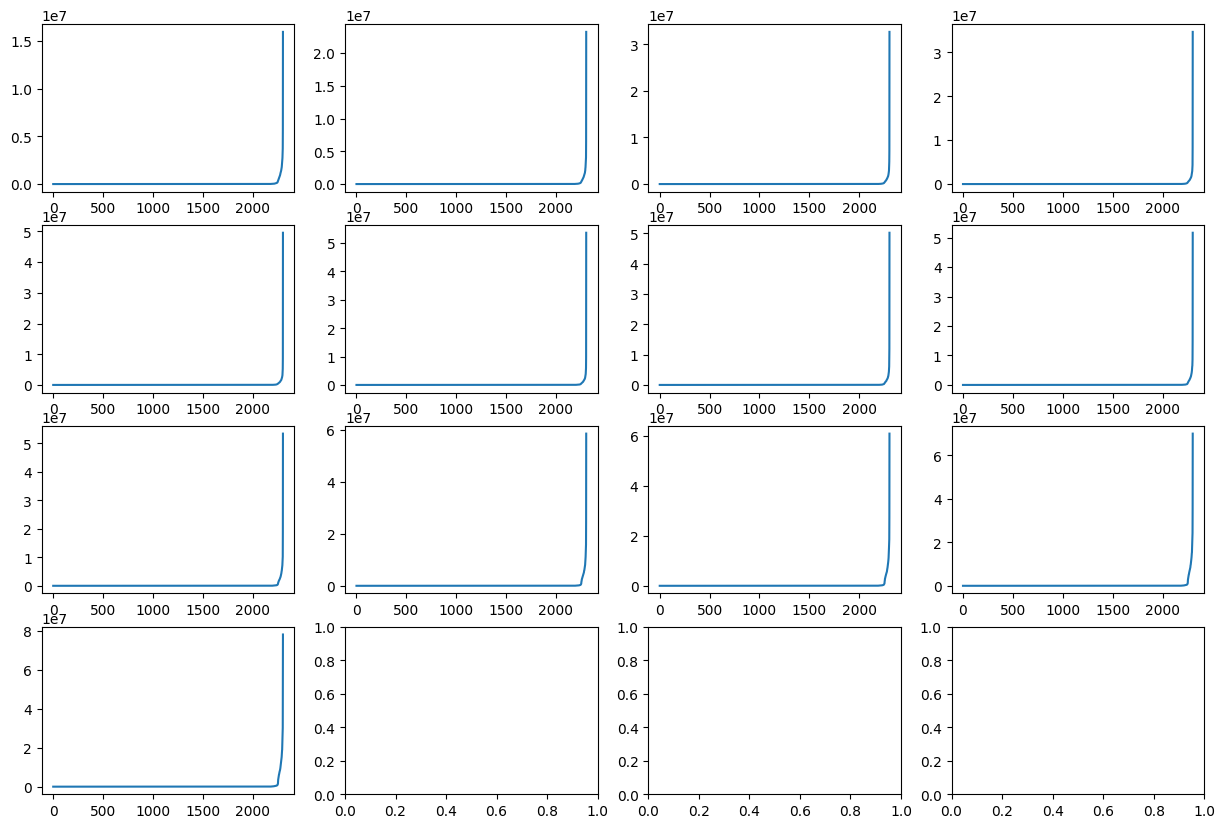

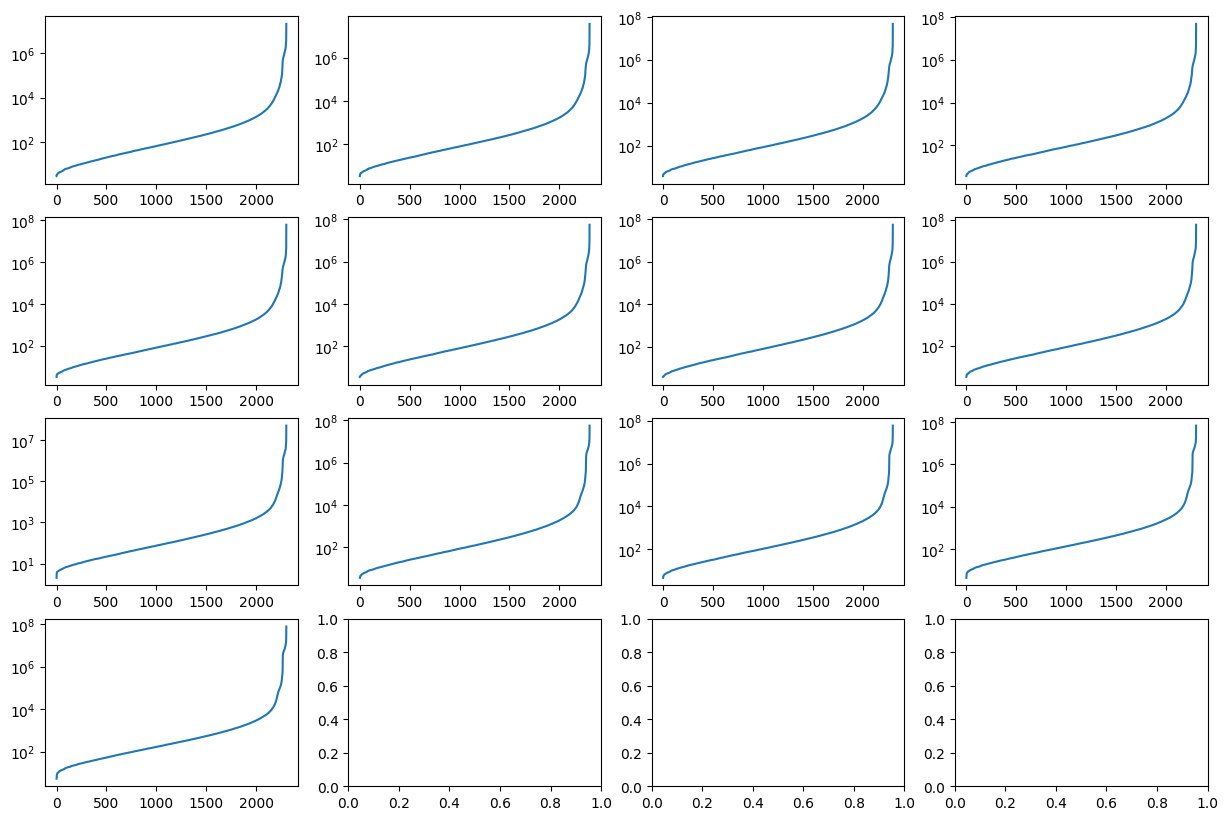

In [23]:
n_viz_col = 4
n_viz_row = math.ceil(n_layers / n_viz_col)

fig, axs1 = plt.subplots(n_viz_row, n_viz_col, figsize=(15, 10))
fig, axs2 = plt.subplots(n_viz_row, n_viz_col, figsize=(15, 10))

for i, ax1 in enumerate(axs1.flatten()):
    if i < n_layers:
        ax1.plot(cov_mat_eigvals_E[i])
for i, ax2 in enumerate(axs2.flatten()):
    if i < n_layers:
        # ax2.set_xscale('log') # not actually tooooo useful I guess
        ax2.set_yscale('log')
        ax2.plot(cov_mat_eigvals_A[i])
